Start of project

In [27]:
library(tidyverse)
library(repr)
library(tidymodels)
options(repr.matrix.max.rows = 6)
source("cleanup.R")

In [41]:
player_data <- read_csv("https://raw.githubusercontent.com/Cna-51/minecraft_indiv/refs/heads/main/players%20(1).csv") |>
    select(-hashedEmail, -name, -experience) |>
    filter(played_hours > 0) |>
    mutate(subscribe = as.factor(subscribe)) |>
    drop_na()
player_data

Rows: 196 Columns: 7
── Column specification ────────────────────────────────────────────────────────
Delimiter: ","
chr (4): experience, hashedEmail, name, gender
dbl (2): played_hours, Age
lgl (1): subscribe

ℹ Use `spec()` to retrieve the full column specification for this data.
ℹ Specify the column types or set `show_col_types = FALSE` to quiet this message.


subscribe,played_hours,gender,Age
<fct>,<dbl>,<chr>,<dbl>
TRUE,30.3,Male,9
TRUE,3.8,Male,17
TRUE,0.7,Female,21
⋮,⋮,⋮,⋮
TRUE,0.1,Female,44
FALSE,0.3,Male,22
FALSE,2.3,Male,17


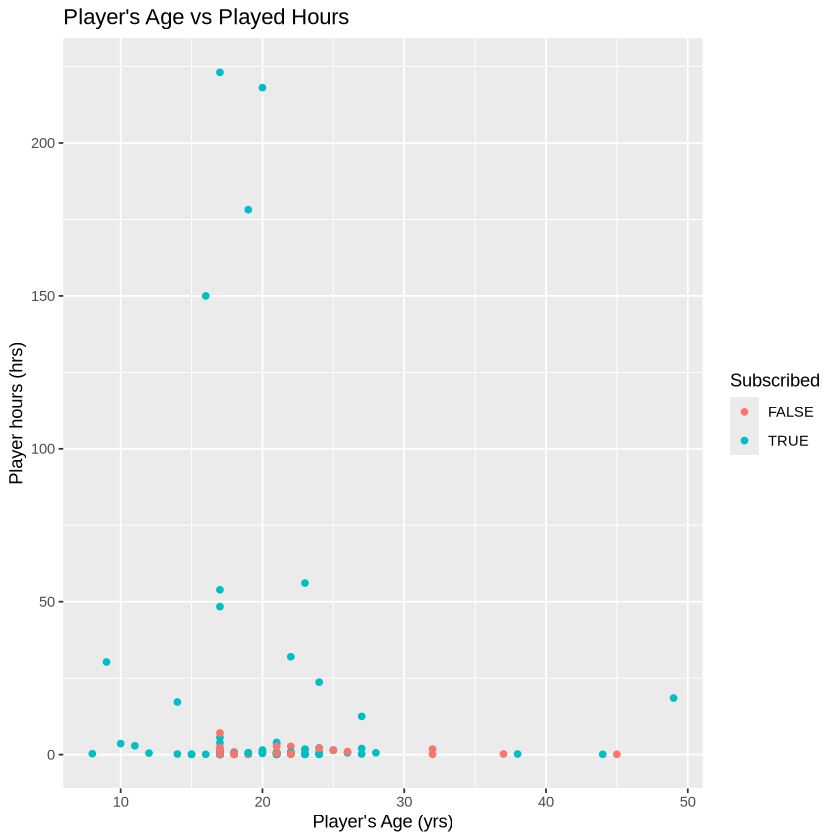

In [42]:
player_plot <- player_data |>
    ggplot(aes(x = Age, y = played_hours, colour = subscribe)) +
    geom_point() +
    labs(x = "Player's Age (yrs)", y = "Player hours (hrs)", colour = "Subscribed", title = "Player's Age vs Played Hours")
player_plot

In [43]:
player_split <- initial_split(player_data, prop= 0.7-0.3, strata= subscribe) 
player_training <- training(player_split)
player_testing <- testing(player_split)
player_training
player_testing

subscribe,played_hours,gender,Age
<fct>,<dbl>,<chr>,<dbl>
FALSE,0.1,Male,18
FALSE,0.9,Male,18
FALSE,0.2,Female,37
⋮,⋮,⋮,⋮
TRUE,0.1,Non-binary,17
TRUE,0.8,Female,22
TRUE,32.0,Male,22


subscribe,played_hours,gender,Age
<fct>,<dbl>,<chr>,<dbl>
TRUE,30.3,Male,9
TRUE,0.1,Male,21
TRUE,1.5,Female,25
⋮,⋮,⋮,⋮
FALSE,0.1,Male,18
TRUE,0.1,Female,44
FALSE,2.3,Male,17


In [44]:
# First, we'll perform a knn classification with k = 3. 
set.seed(1234)
player_recipe <- recipe(subscribe ~ played_hours + Age, data = player_training) |>
    step_scale(all_predictors()) |>
    step_center(all_predictors())
player_spec <- nearest_neighbor(weight_func = "rectangular", neighbors = 3) |>
    set_engine("kknn") |>
    set_mode("classification")
player_fit <- workflow() |>
    add_recipe(player_recipe) |>
    add_model(player_spec) |>
    fit(data = player_training)
player_predictions <- predict(player_fit, player_testing) |>
    bind_cols(player_testing)
prediction_accuracy <- player_predictions |>
        metrics(truth = subscribe, estimate = .pred_class)             
prediction_accuracy

.metric,.estimator,.estimate
<chr>,<chr>,<dbl>
accuracy,binary,0.7424242
kap,binary,0.2489960


In [62]:
# Then a cross validation is performed to test how this model works when split into multiple sections. 
# This will be done while tuning k to determine the most accurate k value. 
vfolds <- vfold_cv(player_training, v = 5, strata = subscribe) 
player_resample <- workflow() |>
    add_recipe(player_recipe) |>
    add_model(player_spec) |>
    fit_resamples(resamples = vfolds) 
resample_metrics <- collect_metrics(player_resample)
player_tune <- nearest_neighbor(weight_func = "rectangular", neighbors = tune()) |>
    set_engine("kknn") |>
    set_mode("classification") 
k_vals <- tibble(neighbors = seq(from = 1, to = 20, by = 1))
tuned_results <- workflow() |>
      add_recipe(player_recipe) |>
      add_model(player_tune) |>
      tune_grid(resamples = vfolds, grid = k_vals) |>
      collect_metrics()
accuracies <- tuned_results |> 
    filter(.metric == "accuracy") |>
    arrange(desc(mean))
accuracies 

neighbors,.metric,.estimator,mean,n,std_err,.config
<dbl>,<chr>,<chr>,<dbl>,<int>,<dbl>,<chr>
7,accuracy,binary,0.7666667,5,0.006804138,Preprocessor1_Model07
8,accuracy,binary,0.7666667,5,0.006804138,Preprocessor1_Model08
11,accuracy,binary,0.7666667,5,0.006804138,Preprocessor1_Model11
⋮,⋮,⋮,⋮,⋮,⋮,⋮
4,accuracy,binary,0.6333333,5,0.1044533,Preprocessor1_Model04
1,accuracy,binary,0.4638889,5,0.1010745,Preprocessor1_Model01
2,accuracy,binary,0.4638889,5,0.1010745,Preprocessor1_Model02


k = 7, 8, and 11 have 76% accuracy. Since the researchers are only hoping to predict whether or not someone will subscribe, and where to concentrate their promotional efforts accordingly, 76% doesn't seem like a bad level of accuravy (to me). 

*we can change/remove this cell this is just me putting my ideas down so I don'